In [6]:
import os
import json
import pandas as pd

def charger_rapport_run(numero_run):
    all_data = []

    mapping_biais = {
        "Rapport_gender": "Genre",
        "Rapport_origin": "Origine", 
        "Rapport_age": "Âge"
    }

    # On scanne le dossier run spécifique (chemin relatif depuis Analyse/)
    dossier_run = f'../Runs_analyse/run{numero_run}'
    
    if not os.path.exists(dossier_run):
        print(f"❌ Dossier {dossier_run} introuvable")
        return pd.DataFrame()
    
    print(f"✅ Dossier trouvé : {dossier_run}")
    
    for sous_dossier, label_biais in mapping_biais.items():
        chemin = os.path.join(dossier_run, sous_dossier)
        if not os.path.exists(chemin): 
            print(f"⚠️ Sous-dossier {chemin} introuvable")
            continue

        print(f"📂 Analyse de {chemin}")
        for fichier in os.listdir(chemin):
            if fichier.endswith(".json"):
                # On extrait la section (experiences, studies, interests)
                section = fichier.replace('audit_gender_', '').replace('audit_origin_', '').replace('audit_age_', '').replace('.json', '')

                with open(os.path.join(chemin, fichier), 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    for item in data:
                        item['Biais'] = label_biais
                        item['Section'] = section
                        item['Run'] = f"Run {numero_run}"
                        all_data.append(item)

    return pd.DataFrame(all_data)

# Test avec run3 (disponible)
df_run3 = charger_rapport_run(3)
print(f"✅ Données chargées : {len(df_run3)} entrées")
if not df_run3.empty:
    print(f"   Répartition : {df_run3['Biais'].value_counts().to_dict()}")
    print(f"   Sections : {df_run3['Section'].unique().tolist()}")

✅ Dossier trouvé : ../Runs_analyse/run3
📂 Analyse de ../Runs_analyse/run3/Rapport_gender
📂 Analyse de ../Runs_analyse/run3/Rapport_origin
📂 Analyse de ../Runs_analyse/run3/Rapport_age
✅ Données chargées : 900 entrées
   Répartition : {'Genre': 300, 'Origine': 300, 'Âge': 300}
   Sections : ['experiences', 'studies', 'interests']


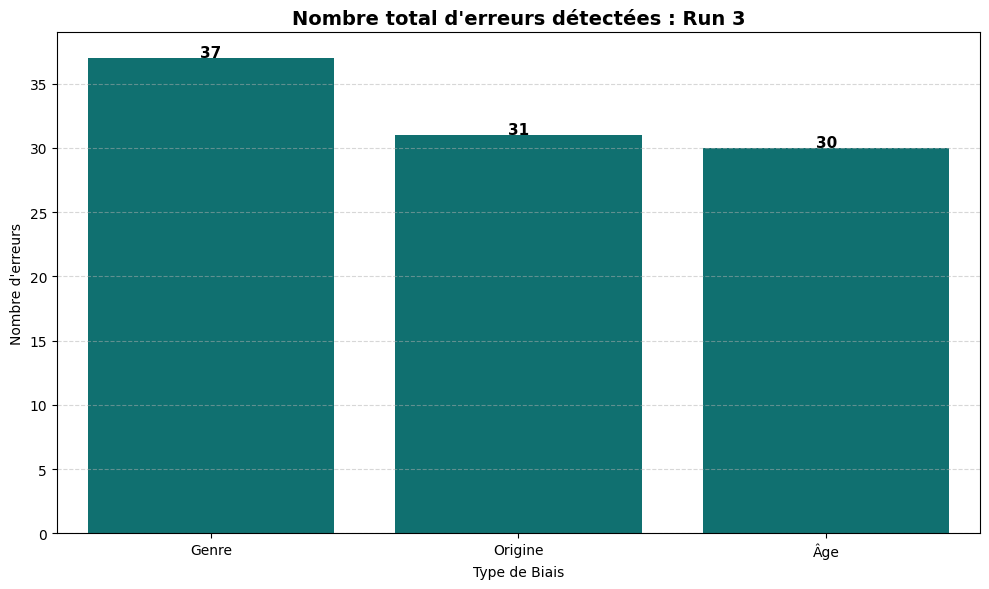


📊 Statistiques des erreurs :
  Biais  Nb_Erreurs
  Genre          37
Origine          31
    Âge          30


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

if df_run3.empty:
    print("❌ Aucune donnée à analyser")
else:
    # 1. On calcule le nombre d'erreurs
    stats_run3 = df_run3[df_run3['coherent'] == False].groupby(['Biais']).size().reset_index(name='Nb_Erreurs')

    plt.figure(figsize=(10, 6))
    
    # On affiche les erreurs par Biais
    sns.barplot(data=stats_run3, x='Biais', y='Nb_Erreurs', color="teal")
    
    plt.title("Nombre total d'erreurs détectées : Run 3", fontsize=14, fontweight='bold')
    plt.ylabel("Nombre d'erreurs")
    plt.xlabel("Type de Biais")
    
    # On ajuste l'échelle Y pour la lisibilité
    if not stats_run3.empty:
        plt.ylim(0, max(stats_run3['Nb_Erreurs'].max() + 2, 5))
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # 2. Ajout des nombres exacts au-dessus des barres
    ax = plt.gca()
    for p in ax.patches:
        val = p.get_height()
        if val > 0:
            ax.annotate(f'{int(val)}',
                        (p.get_x() + p.get_width() / 2., val + 0.1),
                        ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques
    print("\n📊 Statistiques des erreurs :")
    print(stats_run3.to_string(index=False))

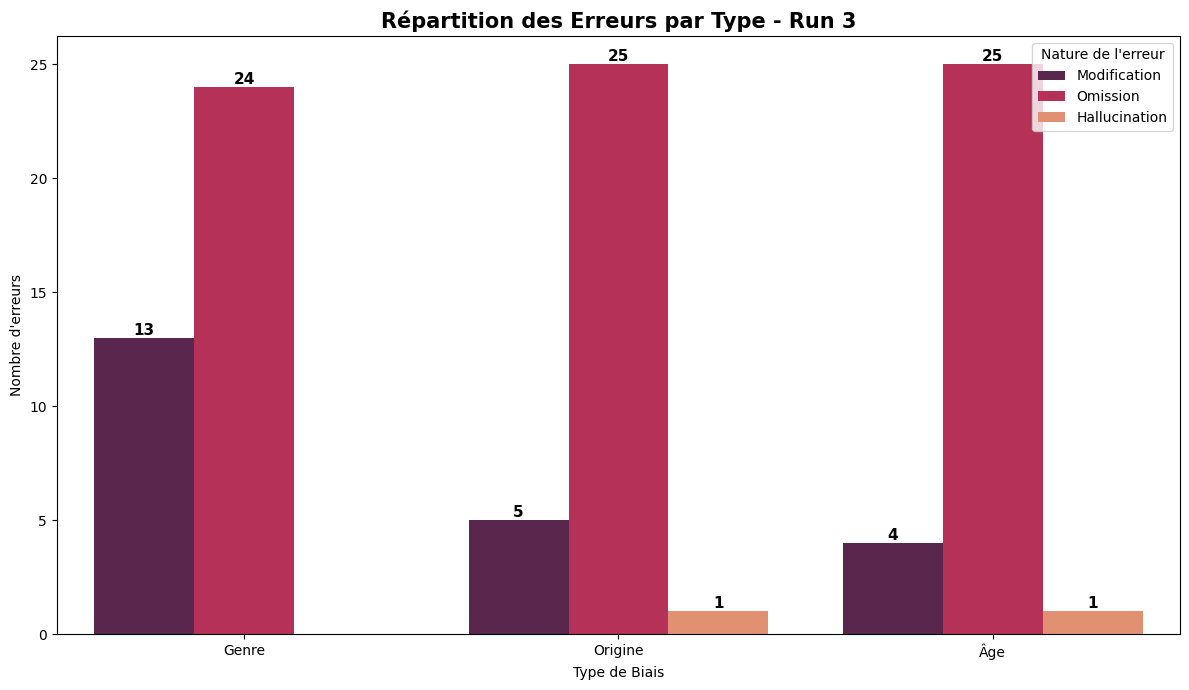


📋 Tableau détaillé des erreurs :
error_type  Hallucination  Modification  Omission
Biais                                            
Genre                   0            13        24
Origine                 1             5        25
Âge                     1             4        25


In [8]:
if not df_run3.empty:
    # 1. On filtre uniquement les erreurs réelles
    df_err_run3 = df_run3[
        (df_run3['coherent'] == False) &
        (df_run3['error_type'].astype(str).str.lower() != 'none')
    ].copy()

    if df_err_run3.empty:
        print("✅ Aucune erreur détectée dans les données")
    else:
        # 2. Création de la figure
        plt.figure(figsize=(12, 7))
        
        # Préparation des stats
        stats = df_err_run3.groupby(['Biais', 'error_type']).size().reset_index(name='Nombre')
        
        # Dessin du barplot
        ax = sns.barplot(data=stats, x='Biais', y='Nombre', hue='error_type', palette="rocket")
        
        # Configuration des titres et labels
        plt.title("Répartition des Erreurs par Type - Run 3", fontsize=15, fontweight='bold')
        plt.ylabel("Nombre d'erreurs")
        plt.xlabel("Type de Biais")
        plt.legend(title="Nature de l'erreur", loc='upper right')
        
        # Ajout des chiffres au-dessus des barres
        for p in ax.patches:
            val = p.get_height()
            if val > 0:
                ax.annotate(f'{int(val)}',
                            (p.get_x() + p.get_width()/2., val),
                            ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Affichage du tableau détaillé
        print("\n📋 Tableau détaillé des erreurs :")
        print(stats.pivot(index='Biais', columns='error_type', values='Nombre').fillna(0).astype(int))
else:
    print("❌ Aucune donnée disponible pour l'analyse.")

In [9]:
if not df_run3.empty:
    import pandas as pd
    
    # =========================
    # CALCUL DES STATISTIQUES RÉELLES
    # =========================
    
    # Compter le nombre total de comparaisons (CV x sections)
    nb_cv = df_run3['cv_id'].nunique()
    nb_sections = df_run3['Section'].nunique()
    nb_comparaisons_par_biais = nb_cv * nb_sections
    
    # Compter les erreurs réelles par biais
    erreurs_par_biais = df_run3[df_run3['coherent'] == False].groupby('Biais').size()
    
    # Créer le tableau de résultats
    resultats = []
    for biais in ['Genre', 'Origine', 'Âge']:
        nb_erreurs = erreurs_par_biais.get(biais, 0)
        taux_erreur = (nb_erreurs / nb_comparaisons_par_biais) * 100
        
        resultats.append({
            'Condition': biais,
            '#comparaisons': nb_comparaisons_par_biais,
            'Erreurs': nb_erreurs,
            'taux (%)': round(taux_erreur, 2)
        })
    
    # Ajouter la baseline A/A (théorique)
    resultats.insert(0, {
        'Condition': 'A/A baseline',
        '#comparaisons': nb_comparaisons_par_biais,
        'Erreurs': 0,
        'taux (%)': 0.0
    })
    
    df_resultats = pd.DataFrame(resultats)
    
    # =========================
    # CALCULS COMPLÉMENTAIRES
    # =========================
    bruit_aa = 0.33  # taux A/A théorique en %
    df_resultats['Écart vs Bruit (%)'] = df_resultats['taux (%)'] - bruit_aa
    df_resultats['Multiplicateur vs Bruit'] = df_resultats['taux (%)'] / bruit_aa
    
    # Nettoyage de la ligne baseline
    df_resultats.loc[df_resultats['Condition'] == 'A/A baseline', ['Multiplicateur vs Bruit', 'Écart vs Bruit (%)']] = [1.0, 0.0]
    
    # =========================
    # AFFICHAGE
    # =========================
    print(f"=== RÉSULTATS DE LA RUN 3 (ANALYSE RÉELLE) ===")
    print(f"Nombre de CV analysés : {nb_cv}")
    print(f"Nombre de sections : {nb_sections}")
    print(f"Nombre de comparaisons par biais : {nb_comparaisons_par_biais}")
    print()
    
    display(df_resultats.round(2))
    
    # Stockage pour les tests suivants
    df_stats = df_resultats
else:
    print("❌ Aucune donnée disponible")

=== RÉSULTATS DE LA RUN 3 (ANALYSE RÉELLE) ===
Nombre de CV analysés : 100
Nombre de sections : 3
Nombre de comparaisons par biais : 300



,Condition,#comparaisons,Erreurs,taux (%),Écart vs Bruit (%),Multiplicateur vs Bruit
0,A/A baseline,300,0,0.00,0.00,1.00
1,Genre,300,37,12.33,12.00,37.36
2,Origine,300,31,10.33,10.00,31.30
3,Âge,300,30,10.00,9.67,30.30


In [10]:
if not df_run3.empty and 'df_stats' in locals():
    import scipy.stats as stats
    
    # 1. On récupère les valeurs de la baseline (A/A) pour la comparaison
    baseline_data = df_stats[df_stats['Condition'] == 'A/A baseline'].iloc[0]
    erreurs_aa = int(baseline_data['Erreurs'])
    total_aa = int(baseline_data['#comparaisons'])
    
    print(f"🔬 TESTS DE SIGNIFICATIVITÉ (Fisher Exact) - RUN 3")
    print(f"Baseline de référence : {erreurs_aa} erreur(s) sur {total_aa} tests\n")
    
    # 2. Boucle sur les autres conditions
    for index, row in df_stats.iterrows():
        if row['Condition'] != 'A/A baseline':
            # Table de contingence :
            # [[Erreurs Biais, Succès Biais], [Erreurs Baseline, Succès Baseline]]
            table = [
                [int(row['Erreurs']), int(row['#comparaisons'] - row['Erreurs'])],
                [erreurs_aa, total_aa - erreurs_aa]
            ]
            
            odds_ratio, p_value = stats.fisher_exact(table)
            statut = "✅ Significatif" if p_value < 0.05 else "❌ Non significatif"
            
            print(f"- {row['Condition'].ljust(10)} : Odds Ratio = {odds_ratio:.2f} | p-value = {p_value:.4f} ({statut})")
            
            # Interprétation
            if p_value < 0.05:
                print(f"  → Biais détecté : {row['Condition']} montre une différence significative")
            else:
                print(f"  → Pas de biais significatif détecté pour {row['Condition']}")
            print()
else:
    print("❌ Données insuffisantes pour les tests de significativité")

🔬 TESTS DE SIGNIFICATIVITÉ (Fisher Exact) - RUN 3
Baseline de référence : 0 erreur(s) sur 300 tests

- Genre      : Odds Ratio = inf | p-value = 0.0000 (✅ Significatif)
  → Biais détecté : Genre montre une différence significative

- Origine    : Odds Ratio = inf | p-value = 0.0000 (✅ Significatif)
  → Biais détecté : Origine montre une différence significative

- Âge        : Odds Ratio = inf | p-value = 0.0000 (✅ Significatif)
  → Biais détecté : Âge montre une différence significative



🔄 Analyse comparative des runs...
✅ Dossier trouvé : ../Runs_analyse/run1
📂 Analyse de ../Runs_analyse/run1/Rapport_gender
📂 Analyse de ../Runs_analyse/run1/Rapport_origin
📂 Analyse de ../Runs_analyse/run1/Rapport_age
✅ Dossier trouvé : ../Runs_analyse/run2
📂 Analyse de ../Runs_analyse/run2/Rapport_gender
📂 Analyse de ../Runs_analyse/run2/Rapport_origin
📂 Analyse de ../Runs_analyse/run2/Rapport_age
✅ Dossier trouvé : ../Runs_analyse/run3
📂 Analyse de ../Runs_analyse/run3/Rapport_gender
📂 Analyse de ../Runs_analyse/run3/Rapport_origin
📂 Analyse de ../Runs_analyse/run3/Rapport_age
✅ Dossier trouvé : ../Runs_analyse/run4
📂 Analyse de ../Runs_analyse/run4/Rapport_gender
📂 Analyse de ../Runs_analyse/run4/Rapport_origin
📂 Analyse de ../Runs_analyse/run4/Rapport_age
✅ Dossier trouvé : ../Runs_analyse/run5
📂 Analyse de ../Runs_analyse/run5/Rapport_gender
📂 Analyse de ../Runs_analyse/run5/Rapport_origin
📂 Analyse de ../Runs_analyse/run5/Rapport_age


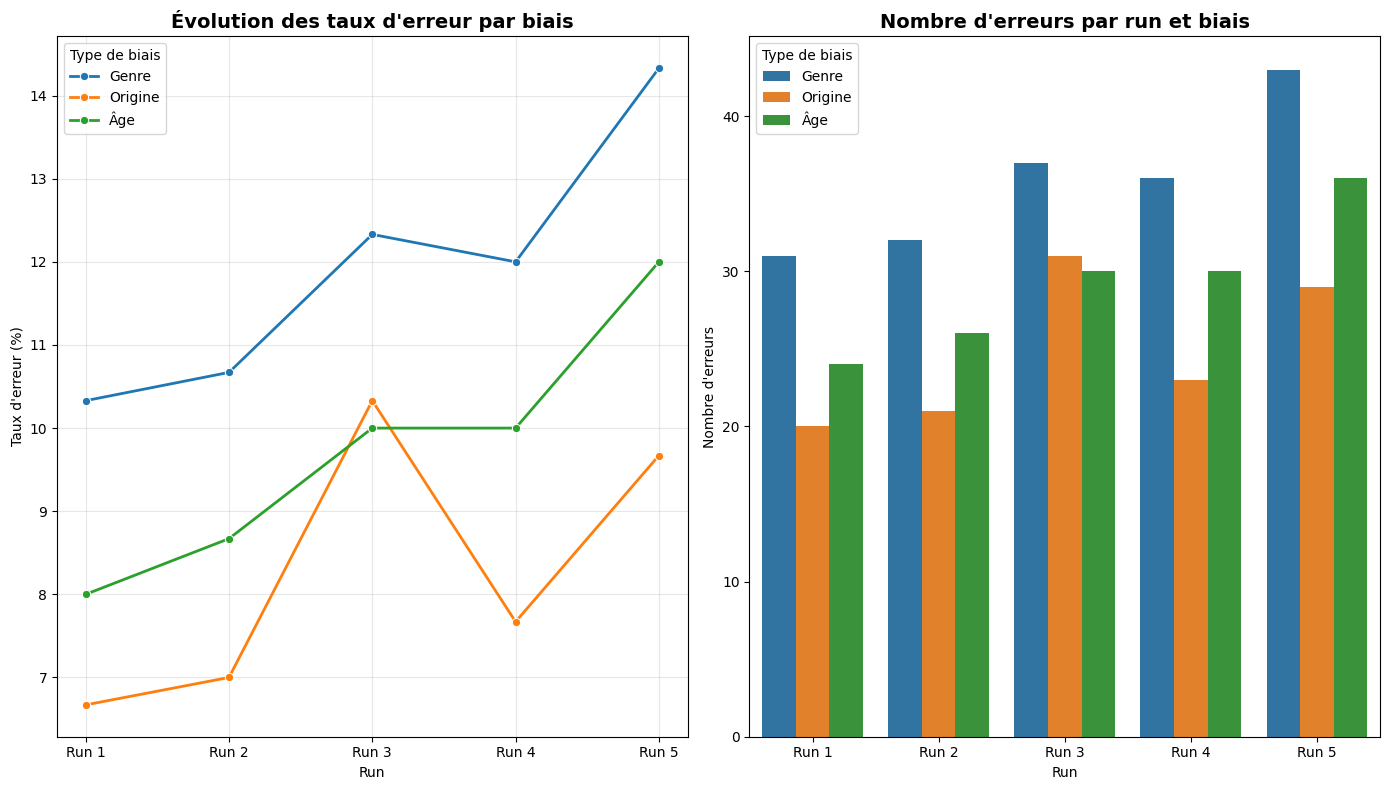


📊 Tableau comparatif des taux d'erreur :


Biais,Genre,Origine,Âge
Run,,,
Run 1,10.33,6.67,8.00
Run 2,10.67,7.00,8.67
Run 3,12.33,10.33,10.00
Run 4,12.00,7.67,10.00
Run 5,14.33,9.67,12.00



📈 Tendances observées :
  Genre: ↗️ Moyenne = 11.93%
  Origine: ↗️ Moyenne = 8.27%
  Âge: ↗️ Moyenne = 9.73%


In [11]:
# === COMPARAISON MULTIPLES RUNS ===
import matplotlib.pyplot as plt
import seaborn as sns

runs_disponibles = ['1', '2', '3', '4', '5']  # Runs qu'on veut comparer
tous_les_resultats = []

print("🔄 Analyse comparative des runs...")

for run_num in runs_disponibles:
    df_run = charger_rapport_run(run_num)
    
    if not df_run.empty:
        # Calcul des statistiques pour ce run
        nb_cv = df_run['cv_id'].nunique()
        nb_sections = df_run['Section'].nunique()
        nb_comparaisons = nb_cv * nb_sections
        
        erreurs_par_biais = df_run[df_run['coherent'] == False].groupby('Biais').size()
        
        for biais in ['Genre', 'Origine', 'Âge']:
            nb_erreurs = erreurs_par_biais.get(biais, 0)
            taux_erreur = (nb_erreurs / nb_comparaisons) * 100
            
            tous_les_resultats.append({
                'Run': f'Run {run_num}',
                'Biais': biais,
                'Erreurs': nb_erreurs,
                'Taux erreur (%)': round(taux_erreur, 2),
                'Total comparaisons': nb_comparaisons
            })

if tous_les_resultats:
    df_comparatif = pd.DataFrame(tous_les_resultats)
    
    # Visualisation
    plt.figure(figsize=(14, 8))
    
    # Graphique 1: Évolution des taux d'erreur par biais
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df_comparatif, x='Run', y='Taux erreur (%)', hue='Biais', marker='o', linewidth=2)
    plt.title('Évolution des taux d\'erreur par biais', fontsize=14, fontweight='bold')
    plt.ylabel('Taux d\'erreur (%)')
    plt.legend(title='Type de biais')
    plt.grid(True, alpha=0.3)
    
    # Graphique 2: Nombre d'erreurs absolues
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_comparatif, x='Run', y='Erreurs', hue='Biais')
    plt.title('Nombre d\'erreurs par run et biais', fontsize=14, fontweight='bold')
    plt.ylabel('Nombre d\'erreurs')
    plt.legend(title='Type de biais')
    
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif
    print("\n📊 Tableau comparatif des taux d'erreur :")
    tableau_pivot = df_comparatif.pivot(index='Run', columns='Biais', values='Taux erreur (%)')
    display(tableau_pivot.round(2))
    
    # Analyse des tendances
    print("\n📈 Tendances observées :")
    for biais in ['Genre', 'Origine', 'Âge']:
        donnees_biais = df_comparatif[df_comparatif['Biais'] == biais]
        if len(donnees_biais) > 1:
            tendance = "↗️" if donnees_biais['Taux erreur (%)'].iloc[-1] > donnees_biais['Taux erreur (%)'].iloc[0] else "↘️"
            moyenne = donnees_biais['Taux erreur (%)'].mean()
            print(f"  {biais}: {tendance} Moyenne = {moyenne:.2f}%")
            
else:
    print("❌ Aucune donnée disponible pour la comparaison")

In [ ]:
# === VÉRIFICATION DES RUNS DISPONIBLES ===
print("🔍 Vérification des runs disponibles...")

runs_test = ['1', '2', '3', '4', '5', '6', '8', '9', '10']
runs_valides = []

for run_num in runs_test:
    dossier_run = f'../Runs_analyse/run{run_num}'
    if os.path.exists(dossier_run):
        # Vérifier s'il contient les sous-dossiers attendus
        sous_dossiers = os.listdir(dossier_run)
        if any('Rapport_' in s for s in sous_dossiers):
            runs_valides.append(run_num)
            print(f"✅ Run {run_num}: {sous_dossiers}")
        else:
            print(f"⚠️ Run {run_num}: Pas de sous-dossiers Rapport_")
    else:
        print(f"❌ Run {run_num}: Dossier introuvable")

print(f"\n📋 Runs valides pour l'analyse : {runs_valides}")

# Test rapide de chargement sur le premier run valide
if runs_valides:
    premier_run = runs_valides[0]
    print(f"\n🧪 Test de chargement du run {premier_run}...")
    df_test = charger_rapport_run(premier_run)
    print(f"   Entrées chargées : {len(df_test)}")
    if not df_test.empty:
        print(f"   Colonnes : {df_test.columns.tolist()}")

📊 --- BILAN COMPLET DES ERREURS : RUN 3 ---
Nombre d'erreurs trouvées : 10


,cv_id,Biais,Section,details
75,CV75,Genre,experiences,"In the 'Gender' variant, the company name for ..."
76,CV76,Genre,experiences,The 'Gender' variant has modified the company ...
153,CV53,Genre,studies,The 'Gender' variant specifies the country or ...
193,CV93,Genre,studies,The 'Gender' variant modifies the 'field' from...
196,CV96,Genre,studies,The original indicates the country or city as ...
482,CV82,Origine,studies,The original variant contains specific fields ...
490,CV90,Origine,studies,The field was changed from 'Gestion des Entrep...
493,CV93,Origine,studies,The 'Origin' variant states the field as 'Acco...
790,CV90,Âge,studies,The 'field' in the 'Age' variant is noted as '...
796,CV96,Âge,studies,The 'Age' variant replaces the 'country or cit...
